In [23]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

pd.set_option('display.max_columns', None)

with open('source_files/assistance-listings.json') as f:
    assistance_listings = pd.read_json(f)

<Axes: xlabel='modifiedDate'>

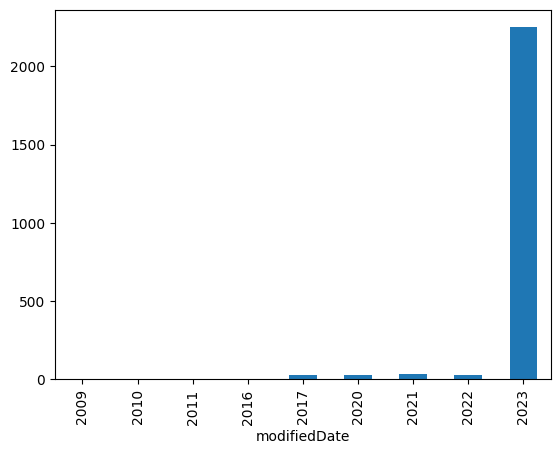

In [57]:
assistance_listings['modifiedDate'] = pd.to_datetime(assistance_listings['modifiedDate'])
assistance_listings.groupby([assistance_listings['modifiedDate'].dt.year]).count()['id'].plot(x='modifiedDate', y='number', kind='bar')

In [70]:
assistance_listings.groupby([assistance_listings['modifiedDate'].dt.year]).count()['id']

modifiedDate
2009       1
2010       1
2011       1
2016       3
2017      27
2020      31
2021      33
2022      30
2023    2249
Name: id, dtype: int64

In [58]:
import csv
import json
import yaml
from decimal import Decimal
from typing import Optional

FISCAL_YEARS = ['2019', '2020', '2021', '2022', '2023'] # this is the list of fiscal years calculated
PRIMARY_FISCAL_YEAR = '2022' # this is the primary year used / displayed across the site
DISPLAY_ENUM_ASSISTANCE_TYPES = {
    'FORMULA GRANTS': 'Formula Grants',
    'PROJECT GRANTS': 'Project Grants',
    'DIRECT PAYMENTS FOR A SPECIFIED USE': 'Direct Payments for a Specified Use',
    'DIRECT PAYMENTS WITH UNRESTRICTED USE': 'Direct Payments with Unrestricted Use',
    'DIRECT LOANS': 'Direct Loans',
    'GUARANTEED/INSURED LOANS': 'Guaranteed/Insured Loans',
    'INSURANCE': 'Insurance',
    'SALE, EXCHANGE, OR DONATION OF PROPERTY OR GOODS': 'Sale, Exchange, or Donation of Property or Goods',
    'USE OF PROPERTY, FACILITIES, OR EQUIPMENT': 'Use of Property, Facilities, or Equipment',
    'PROVISION OF SPECIALIZED SERVICES': 'Provision of Specialized Services',
    'ADVISORY SERVICES AND COUNSELING': 'Advisory Services and Counseling',
    'DISSEMINATION OF TECHNICAL INFORMATION': 'Dissemination of Technical Information',
    'TRAINING': 'Training',
    'INVESTIGATION OF COMPLAINTS': 'Investigation of Complaints',
    'FEDERAL EMPLOYMENT': 'Federal Employment',
    'SALARIES AND EXPENSES': 'Salaries and Expenses',
}

"""                    """
""" BEGIN OBJECT SETUP """
"""                    """

class GenericCategory:
    def __init__(self, id: str, title: str, type: str) -> None:
        self.id: str = id
        self.title: str = title
        self.type: str = type
        self.parent: GenericCategory = None
        self.programs: set[Program] = set()

    def add_program(self, p: 'GenericCategory') -> None:
        self.programs.add(p)

    def set_parent(self, parent: 'GenericCategory') -> None:
        self.parent = parent

    def get_id(self) -> str:
        return self.id
    
    def get_title(self) -> str:
        return self.title
    
    def get_programs(self) -> set['GenericCategory']:
        return self.programs
    
    def get_parent(self) -> 'GenericCategory':
        return self.parent

class Agency(GenericCategory):
    def __init__(self, id: str, title: str) -> None:
        self.id: str = id
        self.title: str = title
        self.type: str = 'agency'
        self.parent: 'Agency' = None
        self.programs: set[Program] = set()

    def set_parent(self, parent: 'Agency') -> None:
        self.parent = parent

    def get_top_level_agency(self) -> 'GenericCategory':
        agency = self
        while agency.parent is not None:
            agency = agency.parent
        return agency

    def get_second_level_agency(self) -> Optional['GenericCategory']:
        agency = self
        while agency.parent is not None:
            if agency.parent.parent is None:
                return agency
            agency = agency.parent
        return None

    def collapse_into_parent(self) -> None:
        if self.parent is None:
            return
        for p in self.programs:
            p.agency = self.parent
            self.parent.add_program(p)

class Program:
    def __init__(self, id: str, title: str, fiscal_years: list[str]) -> None:
        self.id: str = id
        self.title: str = title
        self.agency: Agency = None
        self.applicant_types: set[GenericCategory] = set()
        self.assistance_types: set[GenericCategory] = set()
        self.beneficiary_types: set[GenericCategory] = set()
        self.categories: set[GenericCategory] = set()
        self.spending: dict[str, GenericCategory] = {}
        self.objective: str = ''
        self.fiscal_years: list[str] = fiscal_years
        self.contruct_spending_objects()

    def contruct_spending_objects(self) -> None:
        for y in self.fiscal_years:
            self.spending[y] = ProgramSpendingYear(y)

    def set_agency(self, agency: Agency) -> None:
        self.agency = agency

    def set_objective(self, objective: str) -> None:
        self.objective = objective

    def add_category(self, type: str, category: GenericCategory) -> None:
        getattr(self, type).add(category)
    
    def add_spending(self, year: str, type: str, amount: Decimal) -> None:
        if year not in self.fiscal_years:
            return
        current_amount = getattr(self.spending[year], type)
        if current_amount is None:
            current_amount = Decimal(0)
        setattr(self.spending[year], type, current_amount + amount)
    
    def get_id(self) -> str:
        return self.id

    def get_title(self) -> str:
        return self.title

    def get_agency(self) -> Agency:
        return self.agency
    
    def get_objective(self) -> str:
        return self.objective
    
    def get_category_printable_list(self, type: str, include_top_level: bool = False, include_second_level: bool = False) -> list[str]:
        r = []
        for c in getattr(self, type):
            if include_top_level:
                if c.get_parent() is None:
                    r.append(c.title)
            if include_second_level:
                if c.get_parent() is not None:
                    for p in getattr(self, type):
                        if p.id == c.parent.id:
                            r.append(p.title + ' - ' + c.title)
        return sorted(r)
    
    def get_top_level_agency_printable(self) -> str:
        return self.agency.get_top_level_agency().title

    def get_second_level_agency_printable(self) -> str:
        if self.agency.get_second_level_agency() is None:
            return 'N/A'
        return self.agency.get_second_level_agency().title
        
    def get_obligations_json(self, return_zeros: bool = True) -> str:
        r = []
        for y in self.spending:
            r += self.spending[y].get_list_of_dicts_per_year_per_value(return_zeros)
        return json.dumps(r, separators=(',', ':'))
    
    def get_obligation_value(self, year: str, type: str, return_zeros: bool = True) -> float:
        if year not in self.fiscal_years:
            raise Exception("Provided year not in allowed range")
        return self.spending[year].get_obligation_value(type, return_zeros)

class ProgramSpendingYear:
    def __init__(self, year: str) -> None:
        self.year: str = year
        self.sam_estimate: Decimal = None
        self.sam_actual: Decimal = None
        self.usa_spending_actual: Decimal = None
    
    def get_list_of_dicts_per_year_per_value(self, return_zeros: bool = True) -> list[dict]:
        sam_estimate = float(self.sam_estimate) if self.sam_estimate is not None else None
        sam_actual = float(self.sam_actual) if self.sam_actual is not None else None
        usa_spending_actual = float(self.usa_spending_actual) if self.usa_spending_actual is not None else None
        if return_zeros:
            sam_estimate = sam_estimate if sam_estimate else float(0.0)
            sam_actual = sam_actual if sam_actual else float(0.0)
            usa_spending_actual = usa_spending_actual if usa_spending_actual else float(0.0)
        return [
            {'key': 'SAM.gov Estimate', 'year': self.year, 'amount': sam_estimate},
            {'key': 'SAM.gov Actual', 'year': self.year, 'amount': sam_actual},
            {'key': 'USASpending.gov Obligations', 'year': self.year, 'amount': usa_spending_actual}
        ]

    def get_obligation_value(self, type: str, return_zeros: bool = True) -> float:
        val = float(getattr(self, type)) if getattr(self, type) is not None else None
        if val is None and return_zeros:
            val = float(0.0)
        return val

def convert_to_url_string(s: str) -> str:
    return str(''.join(c if c.isalnum() else '-' for c in s.lower()))

assistance_types: dict[str, GenericCategory] = {}
applicant_types: dict[str, GenericCategory] = {}
beneficiary_types: dict[str, GenericCategory] = {}
with open('source_files/dictionary.json') as f:
    dictionary_list = json.load(f)
    for i in dictionary_list['_embedded']['jSONObjectList']:
        if i['id'] == 'assistance_type':
            for e in i['elements']:
                assistance_types[str(e['element_id'])] = GenericCategory(str(e['element_id']), str(DISPLAY_ENUM_ASSISTANCE_TYPES[e['value']]), 'assistance_type')
                for s in e['elements']:
                    assistance_types[str(s['element_id'])] = GenericCategory(str(s['element_id']), str(s['value']), 'assistance_type')
                    assistance_types[str(s['element_id'])].set_parent(assistance_types[str(e['element_id'])])
        if i['id'] == 'applicant_types':
            for e in i['elements']:
                applicant_types[str(e['element_id'])] = GenericCategory(str(e['element_id']), str(e['value']), 'applicant_type')
        if i['id'] == 'beneficiary_types':
            for e in i['elements']:
                beneficiary_types[str(e['element_id'])] = GenericCategory(str(e['element_id']), str(e['value']), 'beneficiary_type')

agencies: dict = {}
with open('source_files/organizations.json') as f:
    # insert a default agency, for programs that are incorrectly tagged
    agencies['unspecified'] = Agency('unspecified', 'Unspecified')
    organizations_list = json.load(f)
    # create and load Agency objects
    for o in organizations_list:
        agencies[str(o['orgKey'])] = Agency(str(o['orgKey']), str(o.get('agencyName', o.get('name', ''))))
    # assign parent Agency object, where appropriate
    for o in organizations_list:
        if o.get('parentOrgKey', False) and agencies.get(str(o['parentOrgKey']), False):
            agencies[str(o['orgKey'])].set_parent(agencies[str(o['parentOrgKey'])])

categories: dict = {}
with open('source_files/2022-program-to-function-sub-function.csv', newline='') as f:
    r = csv.reader(f)
    for row in r:
        if convert_to_url_string(row[1]) not in categories:
            categories[convert_to_url_string(row[1])] = GenericCategory(convert_to_url_string(row[1]), str(row[1]), 'category')
        if convert_to_url_string(row[1]+'---'+row[2]) not in categories:
            categories[convert_to_url_string(row[1]+'---'+row[2])] = GenericCategory(convert_to_url_string(row[1]+'---'+row[2]), str(row[2]), 'category')
            categories[convert_to_url_string(row[1]+'---'+row[2])].set_parent(categories[convert_to_url_string(row[1])])

programs: dict = {}
with open('source_files/assistance-listings.json') as f:
    assistance_listings_list = json.load(f)
    for l in assistance_listings_list:
        d = l['data']
        program = Program(str(d['programNumber']), str(d['title']), FISCAL_YEARS)
        agency = agencies.get('unspecified') # default to 'unspecified' agency
        if agencies.get(str(d['organizationId']), False):
            agency = agencies.get(str(d['organizationId']))
        program.set_agency(agency)
        program.set_objective(str(d['objective']))
        program.get_agency().add_program(program)
        programs[str(l['data']['programNumber'])] = program
        for o in l['data']['financial']['obligations']:
            for row in o.get('values', []):
                if str(row['year']) in FISCAL_YEARS:
                    if row.get('actual'):
                        program.add_spending(str(row['year']), 'sam_actual', Decimal(row['actual']))
                    if row.get('estimate'):
                        program.add_spending(str(row['year']), 'sam_estimate', Decimal(row['estimate']))
        for e in l['data']['financial']['obligations']:
            if e.get('assistanceType', False):
                program.add_category('assistance_types', assistance_types[e['assistanceType']])
                program.add_category('assistance_types', assistance_types[e['assistanceType']].get_parent())
                assistance_types[e['assistanceType']].add_program(program)
                assistance_types[e['assistanceType']].get_parent().add_program(program)
        for e in l['data']['eligibility']['beneficiary']['types']:
                program.add_category('beneficiary_types', beneficiary_types[e])
                beneficiary_types[e].add_program(program)
        for e in l['data']['eligibility']['applicant']['types']:
                program.add_category('applicant_types', applicant_types[e])
                applicant_types[e].add_program(program)

# populate USASpending.gov data into Programs
with open('source_files/usaspending_db_obligations_by_program.csv', newline='') as f:
    r = csv.reader(f)
    next(r) # skip the header row
    for row in r:
        if str(row[1]) in programs:
            programs[str(row[1])].add_spending(str(row[0]), 'usa_spending_actual', Decimal(row[3]))

# populate Programs into Categories
with open('source_files/2022-program-to-function-sub-function.csv', newline='') as f:
    r = csv.reader(f)
    for row in r:
        if str(row[0]) in programs:
            program = programs[str(row[0])]
            category = categories[convert_to_url_string(row[1])]
            subcategory = categories[convert_to_url_string(row[1]+'---'+row[2])]
            program.add_category('categories', category)
            program.add_category('categories', subcategory)
            category.add_program(program)
            subcategory.add_program(program)

# condense agencies down to two tiers
while len([a for a in agencies if agencies[a].get_parent() is not None and agencies[a].get_parent().get_parent() is not None]):
    remove = []
    for a in agencies:
        if agencies[a].get_parent() is not None and agencies[a].get_parent().get_parent() is not None:
            agencies[a].collapse_into_parent()
            remove.append(a)
    for r in remove:
        agencies.pop(r)


"""                  """
""" END OBJECT SETUP """
"""                  """

# build a markdown file for each program using Jekyll's required format
for p in programs:
    program = programs[p]
    with open('../website/_program/'+program.get_id()+'.md', 'w') as file:
        file.write('---\n') # Begin Jekyll Front Matter
        listing = {
            'title': program.get_title(),
            'layout': 'program',
            'permalink': '/program/' + program.get_id() + '.html',
            'fiscal_year': PRIMARY_FISCAL_YEAR,

            'cfda': program.get_id(),
            'objective': program.get_objective(),
            'assistance_types': program.get_category_printable_list('assistance_types', True),
            'beneficiary_types': program.get_category_printable_list('beneficiary_types', True),
            'applicant_types': program.get_category_printable_list('applicant_types', True),
            'categories': program.get_category_printable_list('categories', True, True),
            'agency': program.get_top_level_agency_printable(),
            'sub-agency': program.get_second_level_agency_printable(),
            'obligations': program.get_obligations_json()
        }
        yaml.dump(listing, file)
        file.write('---\n') # End Jekyll Front Matter

# build a markdown file for each category & sub-category using Jekyll's required format


# build a markdown file for the category index page using Jekyll's required format
with open('../website/pages/category.md', 'w') as file:
    file.write('---\n') # Begin Jekyll Front Matter
    listing = {
        'title': 'Categories',
        'layout': 'category-index',
        'permalink': '/category.html',
        'fiscal_year': PRIMARY_FISCAL_YEAR,

        'total_num_programs': len(programs),
        'total_obs': sum(programs[p].get_obligation_value(PRIMARY_FISCAL_YEAR, 'sam_actual') for p in programs),
        'categories': sorted([
            {
                'title': categories[c].get_title(),
                'permalink': '/category/'+categories[c].get_id(),
            } for c in categories if (categories[c].get_parent() is None)
        ], key=lambda category: category['title']),
        'categories_json': json.dumps(sorted([
            {
                'title': categories[c].get_title(),
                'total_num_programs': len(categories[c].programs),
                'total_obs': sum(p.get_obligation_value(PRIMARY_FISCAL_YEAR, 'sam_actual') for p in categories[c].get_programs()),
                'permalink': '/category/'+categories[c].get_id()
            } for c in categories if (categories[c].get_parent() is None)
        ], key=lambda category: category['total_obs'], reverse=True), separators=(',', ':'))
    }
    yaml.dump(listing, file)
    file.write('---\n') # End Jekyll Front Matter

# build the markdown file for the search page using Jekyll's required format
def generate_list_of_program_ids_for_category(categories: list[GenericCategory], two_tier: bool = False) -> list[dict [str, list[str]]]:
    r: list[dict] = []
    for key in categories:
        category: GenericCategory = categories[key]
        if not two_tier or (two_tier and category.get_parent() is None):
            o = {
                'title': category.get_title(),
                'programs': [p.get_id() for p in category.get_programs()]
            }
            if two_tier:
                all_programs: set = set(p.get_id() for p in category.get_programs())
                o['sub_categories']: list = []
                for child_key in categories:
                    child: GenericCategory = categories[child_key]
                    if child.get_parent() == category:
                        o['sub_categories'].append(
                            {
                                'title': child.get_title(),
                                'programs': [p.get_id() for p in child.get_programs()]
                            }
                        )
                        all_programs -= set(p.get_id() for p in child.get_programs())
                if len(all_programs):
                    o['sub_categories'].append(
                        {
                            'title': 'Unspecified',
                            'programs': [p.get_id() for p in child.get_programs()]
                        }
                    )
            r.append(o)
    return sorted(r, key=lambda cat: cat['title'])

with open('../website/pages/search.md', 'w') as file:
    file.write('---\n') # Begin Jekyll Front Matter
    page = {
        'title': 'Search',
        'layout': 'search',
        'permalink': '/search.html',
        'fiscal_year': PRIMARY_FISCAL_YEAR,

        'agencies': generate_list_of_program_ids_for_category(agencies, True),
        'applicant_types': generate_list_of_program_ids_for_category(applicant_types),
        'assistance_types': generate_list_of_program_ids_for_category(assistance_types, True),
        'beneficiary_types': generate_list_of_program_ids_for_category(beneficiary_types),
        'categories': generate_list_of_program_ids_for_category(categories, True),
        'programs': json.dumps(sorted([
            {
                'cfda': programs[p].get_id(),
                'title': programs[p].get_title(),
                'permalink': '/program/' + programs[p].get_id(),
                'agency': programs[p].get_top_level_agency_printable(),
                'obligations': programs[p].get_obligation_value(PRIMARY_FISCAL_YEAR, 'sam_actual')
            } for p in programs
        ], key=lambda program: program['obligations'], reverse=True), separators=(',', ':'))
    }
    yaml.dump(page, file)
    file.write('---\n') # End Jekyll Front Matter

In [79]:
programs_df = pd.DataFrame([(programs[p].get_id(), programs[p].get_obligation_value(PRIMARY_FISCAL_YEAR, 'usa_spending_actual')) for p in programs if programs[p].get_obligation_value(PRIMARY_FISCAL_YEAR, 'usa_spending_actual') == 0])
programs_df.groupby(programs_df[1]).count()


,0
1,
0.0,552
